In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import random

from keras import metrics
from keras import backend
from keras import models
from keras import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization
from keras import optimizers
from keras.utils import to_categorical
from keras import regularizers
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping #,ModelCheckpoint
#from keras.preprocessing.image import ImageDataGenerator # for whatever reason, computer hates this
from tensorflow.keras.preprocessing.image import ImageDataGenerator # but this works
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.preprocessing import image
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [5]:
# set seed for reproducibility
seed_value = 2024
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

In [6]:
### paths
train_aug_path = "../Organized_Data/augmented_train/"
#orig_train_path = "../Organized_Data/train/" # no data augmentation 
test_path = "../Organized_Data/test/" 

In [10]:
## reading in data
train_set = ImageDataGenerator(rescale = 1./255)

train_set = train_set.flow_from_directory(
    directory = train_aug_path,
    target_size = (150,150),
    batch_size = 128, # changed to 128 from 64 because pretty husky data
    class_mode = 'categorical'
)

test_set = ImageDataGenerator(rescale = 1./255)

test_set = test_set.flow_from_directory(
    directory=test_path,
    target_size = (150,150),
    batch_size = 128,
    class_mode = 'categorical',
    shuffle=False
)

Found 46481 images belonging to 4 classes.
Found 9272 images belonging to 4 classes.


In [9]:
46481/64 # steps per epoch ## 726.265625

46481/128

363.1328125

/Users/rosemarymejia/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/rosemarymejia/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


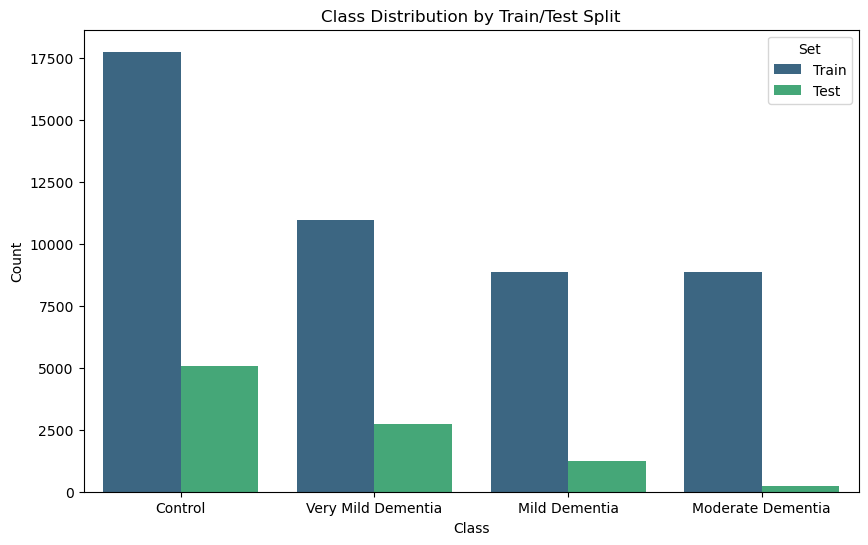

In [15]:
category_colors = sns.color_palette("viridis", n_colors=2)

train_labels = train_set.class_indices
test_labels = test_set.class_indices

train_counts = train_set.classes
test_counts = test_set.classes

data = {
    'Class': list(train_labels.keys()) * 2,
    'Count': [list(train_counts).count(i) for i in range(len(train_labels))] + [list(test_counts).count(i) for i in range(len(test_labels))],
    'Set': ['Train'] * len(train_labels) + ['Test'] * len(test_labels)
}

df = pd.DataFrame(data)

# reorder classes
order = ["Control", "Very Mild Dementia", "Mild Dementia", "Moderate Dementia"]
df['Class'] = pd.Categorical(df['Class'], categories=order, ordered=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Class', y='Count', hue='Set', data=df.sort_values('Class'), palette=category_colors)
plt.title('Class Distribution by Train/Test Split')
plt.show()

In [17]:
early_stopping = EarlyStopping(monitor='loss',  # no validation set :'(
                               patience=2, 
                               restore_best_weights = True)

In [19]:
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPool2D(2),
    BatchNormalization(),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPool2D(2),
    BatchNormalization(),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPool2D(2),
    BatchNormalization(),
    Dropout(0.5),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

In [20]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 74, 74, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 36, 36, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 17, 17, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 17, 17, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4624)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │       148,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,228 (610.27 KB)

 Trainable params: 156,100 (609.77 KB)

 Non-trainable params: 128 (512.00 B)

In [21]:
model2.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy', 'precision', 'recall']
)

In [22]:
history2 = model2.fit(
    train_set,
    epochs= 10,
    callbacks = early_stopping,
    verbose=1
)

Epoch 1/10


/Users/rosemarymejia/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


364/364 ━━━━━━━━━━━━━━━━━━━━ 531s 1s/step - accuracy: 0.7246 - loss: 0.6958 - precision: 0.7826 - recall: 0.6651
Epoch 2/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 528s 1s/step - accuracy: 0.9637 - loss: 0.1051 - precision: 0.9667 - recall: 0.9605
Epoch 3/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 528s 1s/step - accuracy: 0.9831 - loss: 0.0476 - precision: 0.9844 - recall: 0.9823
Epoch 4/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 527s 1s/step - accuracy: 0.9914 - loss: 0.0257 - precision: 0.9917 - recall: 0.9910
Epoch 5/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 527s 1s/step - accuracy: 0.9910 - loss: 0.0260 - precision: 0.9914 - recall: 0.9907
Epoch 6/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 525s 1s/step - accuracy: 0.9923 - loss: 0.0230 - precision: 0.9926 - recall: 0.9922
Epoch 7/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 517s 1s/step - accuracy: 0.9954 - loss: 0.0140 - precision: 0.9955 - recall: 0.9953
Epoch 8/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 721s 2s/step - accuracy: 0.9944 - loss: 0.0172 - precision: 0.9946 - recall: 0.9943
Epoch 9/10
364/364 

In [38]:
model2.save('../Models/model_2a_customized_3_layer_cnn.keras')

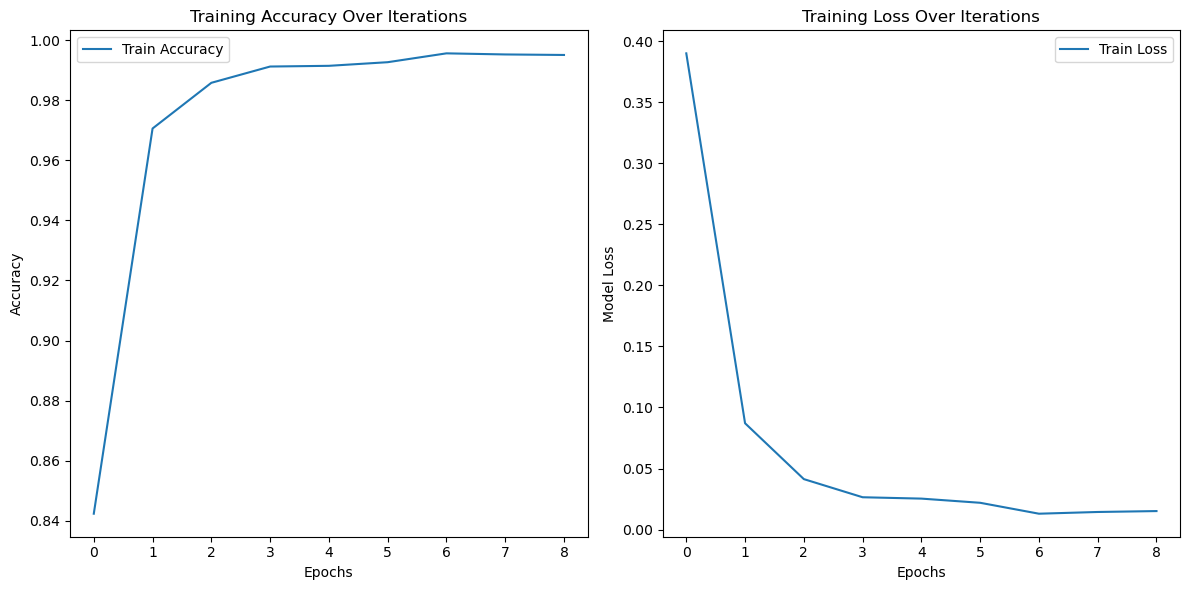

In [33]:
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Iterations')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Model Loss')
plt.title('Training Loss Over Iterations')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
y_pred = model2.predict(test_set)

/Users/rosemarymejia/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


73/73 ━━━━━━━━━━━━━━━━━━━━ 36s 492ms/step


In [26]:
predicted_classes = np.argmax(y_pred, axis=1)
print(predicted_classes)

[0 0 0 ... 0 1 1]


In [27]:
true_classes = test_set.classes

In [28]:
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 62.49%


In [29]:
class_labels = list(test_set.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

                    precision    recall  f1-score   support

           Control       0.70      0.94      0.80      5063
     Mild Dementia       0.31      0.30      0.30      1220
 Moderate Dementia       0.00      0.00      0.00       244
Very Mild Dementia       0.53      0.25      0.34      2745

          accuracy                           0.62      9272
         macro avg       0.38      0.37      0.36      9272
      weighted avg       0.58      0.62      0.58      9272



In [30]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[4756  260   13   34]
 [ 377  363    6  474]
 [ 151    9    0   84]
 [1515  555    0  675]]


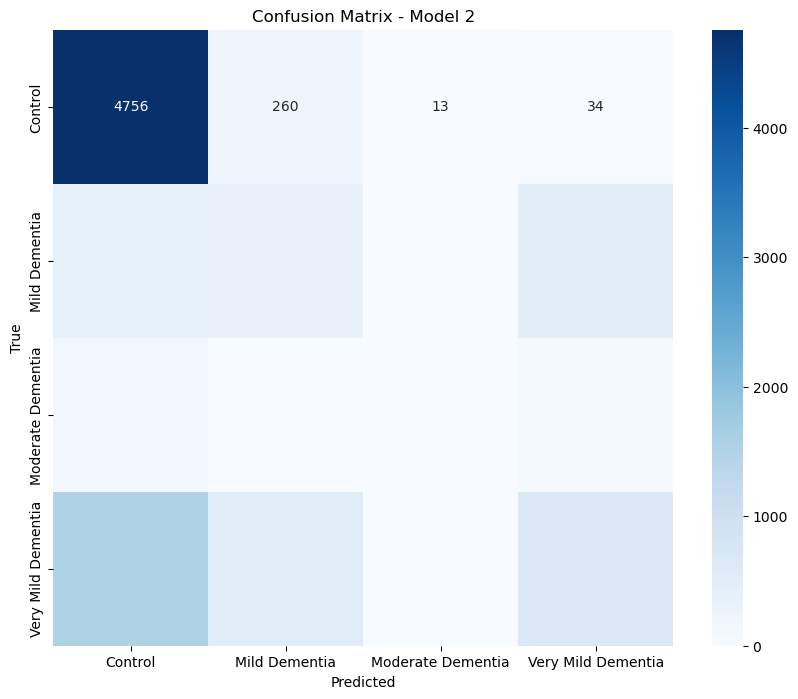

In [35]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=0)
plt.title('Confusion Matrix - Model 2')
plt.show()